Installing Transformers

We use transformers library to carry out all the NLP(Natural Language Processing) tasks.

In [2]:
!pip install Transformers

!pip install Torch

!pip install datasets


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

load dataset

In [3]:

!pip install huggingface_hub==0.14.1
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.5
    Uninstalling huggingface-hub-0.23.5:
      Successfully uninstalled huggingface-hub-0.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.14.1 which is incompatible.
tokenizers 0.19.1 requires huggingface-hub<1.0,>=0.16.4, but you have huggingface-hub 0.14.1 which is incompatible.
transformers 4.42.4 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.14.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.14.1
    Uninstalling huggingface-hub-0.

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [28]:
# import libraries
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split


In [21]:


# Load the AG News dataset
from datasets import load_dataset

ds = load_dataset("raquiba/Sarcasm_News_Headline")

# Extract the training set as a Pandas DataFrame
train_df = ds['train'].to_pandas()
# Use the 'rename' method to change the column name
train_df = train_df.rename(columns={'is_sarcastic': 'labels'})
train_df = train_df.drop('article_link', axis=1) # Drop the 'article_link' column

# Print the first few rows of the DataFrame
print(train_df.head())

# Extract the features and labels as NumPy arrays
X = train_df['headline'].values  # Assuming 'text' column contains the features
y = train_df['labels'].values  # Assuming 'label' column contains the labels

# split train set to train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)  # Adjust test_size as needed

# Create DataFrames for the validation set
val_df = pd.DataFrame({ 'labels': y_val,'headline': X_val,})
val_df = val_df.rename(columns={'is_sarcastic': 'labels'})

# Print the first few rows of the validation DataFrame
print(val_df.head())
print(val_df.columns)
# Convert to Pandas DataFrames (for each split if needed)
# train_df is already a DataFrame
test_df = ds['test'].to_pandas()
test_df = test_df.drop('article_link', axis=1) # Drop the 'article_link' column
test_df = test_df.rename(columns={'is_sarcastic': 'labels'})
# val_df is now a DataFrame

print(train_df.columns)
print(test_df.columns)
print(test_df.head(5))

Repo card metadata block was not found. Setting CardData to empty.


   labels                                           headline
0       1  thirtysomething scientists unveil doomsday clo...
1       0  dem rep. totally nails why congress is falling...
2       0  eat your veggies: 9 deliciously different recipes
3       1  inclement weather prevents liar from getting t...
4       1  mother comes pretty close to using word 'strea...
   labels                                           headline
0       0  the vietnam war is not history for victims of ...
1       0        4 personal tips to set up for sleep success
2       0  amid protests, greece passes painful reforms t...
3       0  wisconsin students trumped the rest with their...
4       1     boyfriend not to be trusted with netflix queue
Index(['labels', 'headline'], dtype='object')
Index(['labels', 'headline'], dtype='object')
Index(['labels', 'headline'], dtype='object')
   labels                                           headline
0       0  former versace store clerk sues over secret 'b...
1       

In [15]:
# check for null data
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    28619 non-null  int64 
 1   headline  28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [16]:
# take acopy of train_df for eda
df = train_df.copy()
# count the label class into dictionary
label_count = df['labels'].replace({0:'not sarcastic', 1:'sarcastic'}).value_counts().to_dict()

print(label_count)

{'not sarcastic': 14985, 'sarcastic': 13634}


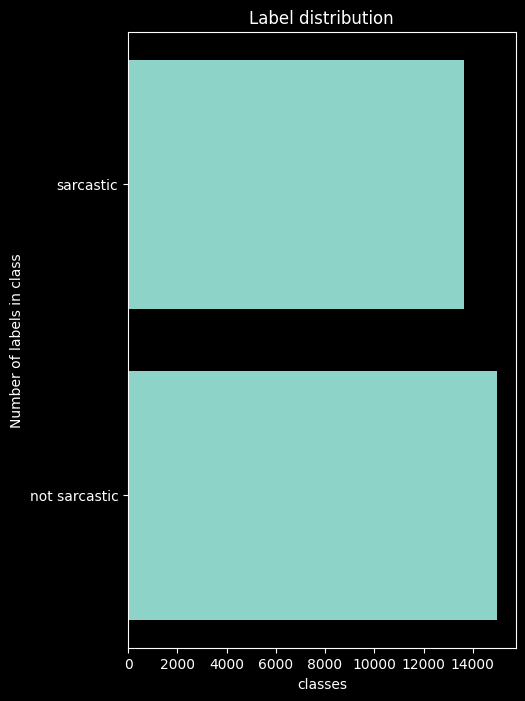

In [17]:
# plot bar chart for label class
plt.style.use("dark_background")# set background to dark
plt.figure(figsize=(5, 8)) # set figure size
plt.barh(list(label_count.keys()), list(label_count.values())) # plot bar chart using label_count ddict
plt.xlabel('classes') # set xxaxis label
plt.ylabel('Number of labels in class') # set yaxis label
plt.title('Label distribution')
plt.show() # show plot

In [22]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from sklearn.model_selection import train_test_split

# ... rest of your code ...

# Initialize the tokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Rename the 'is_sarcastic' column to 'labels' in the training dataset
ds['train'] = ds['train'].rename_column('is_sarcastic', 'labels')
ds['test'] = ds['test'].rename_column('is_sarcastic', 'labels')

def preprocess_function(examples):
    # Tokenize the examples and add 'labels' column
    tokenized_inputs = tokenizer(examples['headline'], padding="max_length", truncation=True)
    # Use 'labels' key instead of 'is_sarcastic' to match the training data

    return tokenized_inputs



# Apply the preprocessing function to the dataset
tokenized_train = ds['train'].map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(['article_link'])

# Convert the validation DataFrame to a Hugging Face Dataset
val_dataset = Dataset.from_pandas(val_df) # Dataset is now imported

# Apply the preprocessing function to the validation dataset
tokenized_val = val_dataset.map(preprocess_function, batched=True)

tokenized_val = tokenized_val.remove_columns(['attention_mask'])

tokenized_test = ds['test'].map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns(['article_link'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(tokenized_train)
print(tokenized_val)
print(tokenized_test)

Map:   0%|          | 0/5724 [00:00<?, ? examples/s]

Map:   0%|          | 0/26709 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'headline', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 28619
})
Dataset({
    features: ['labels', 'headline', 'input_ids', 'token_type_ids'],
    num_rows: 5724
})
Dataset({
    features: ['labels', 'headline', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 26709
})


In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',            # Directory to save checkpoints and model
    num_train_epochs=2,                # Number of training epochs
    per_device_train_batch_size=16,    # Batch size per device during training
    per_device_eval_batch_size=16,     # Batch size per device during evaluation
    warmup_steps=500,                  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Strength of weight decay
    logging_dir='./logs',              # Directory for storing logs
    logging_steps=10,                  # Log every X updates
    evaluation_strategy="epoch",       # Evaluate every epoch
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
from transformers import Trainer, AutoModelForSequenceClassification

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0)  # Set zero_division to 0
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels for sarcasm detection

trainer = Trainer(
    model=model,                        # The model to train
    args=training_args,                 # Training arguments
    train_dataset=tokenized_train,      # Training dataset
    eval_dataset=tokenized_val,         # Evaluation dataset
    tokenizer=tokenizer,                # The tokenizer used for preprocessing
    data_collator=data_collator,
    compute_metrics=compute_metrics     # Data collator for dynamic padding
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss


In [32]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.6981616020202637, 'eval_accuracy': 0.5179944095038435, 'eval_f1': 0.3535167278579574, 'eval_precision': 0.26831820827723546, 'eval_recall': 0.5179944095038435, 'eval_runtime': 85.2312, 'eval_samples_per_second': 67.158, 'eval_steps_per_second': 4.2}


In [ ]:
print(tokenized_val)

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler, default_data_collator

# Assuming you have already tokenized the datasets as tokenized_train, tokenized_val, tokenized_test

# Prepare DataLoaders, use default_data_collator to ensure correct format
train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=8, collate_fn=default_data_collator)
eval_dataloader = DataLoader(tokenized_val, batch_size=8, collate_fn=default_data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=8, collate_fn=default_data_collator)

# Choose a model (e.g., BERT)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels for sarcasm detection

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_dataloader) * 2  # Replace num_epochs with desired number of epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Training loop (example)
num_epochs = 2  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        # Remove 'is_sarcastic' from the batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['is_sarcastic'].to(device)  # Extract labels separately

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # Access loss directly from outputs
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    # Evaluation loop (example)
    model.eval()
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            # Calculate evaluation metrics here (e.g., accuracy)

# Testing loop (example)
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        # Calculate and report test metrics

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [ ]:
from transformers import AutoTokenizer

# Assuming you want to use the standard '[PAD]' token
tokenizer.pad_token = '[PAD]'
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=ds['train'], # Access the 'train' split of the dataset as an attribute
    eval_dataset=ds['train'], # Access the 'validation' split of the dataset as an attribute
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [ ]:
from transformers import Trainer, EvalPrediction, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for checkpoints and metrics
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size per device during training
    # ... other training arguments ...
)

# Define a function to compute the accuracy
def compute_metrics(pred):
  labels = pred.label_ids
  preds = np.argmax(pred.predictions, axis=1)
  return {"accuracy": (preds == labels).mean()}

# Apply padding and truncation to the tokenizer
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to EOS token
tokenizer.padding_side = "right"  # Choose "right" or "left" based on your model

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train, # Make sure this dataset includes labels!
    eval_dataset=tokenized_train,
    compute_metrics=compute_metrics, # Add the compute_metrics function
    tokenizer=tokenizer,

)

trainer.train()

In [ ]:
tokenized_train

In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

In [ ]:
import pandas as pd

# Load your dataset from a CSV file (adjust the path to your file)
df = ds['train'].to_pandas()

# Preview the first few rows of the dataset
print(df.columns
      ,df.head())

# Extract texts and labels from the DataFrame
#texts = df['text'].tolist()  # Assuming your text column is named 'text'
#labels = df['label'].tolist()  # Assuming your label column is named 'label'


text classification

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="google-bert/bert-base-uncased")

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")